In [1]:
from utils import misc
import yaml
from easydict import EasyDict
from datasets import build_dataset_from_cfg
import csv
import numpy as np
import glob
import open3d as o3d
from PIL import Image

def convert_to_o3dpcd(points, colour=None):
    if type(points) == list:
        pcds = []
        for pointcloud in points:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pointcloud[:,:3])
            pcds.append(pcd)
        return pcds
    else:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[:,:3])
        if colour:
            pcd.paint_uniform_color(np.array(colour))
        return pcd
    
def boxpts_to_o3dbox(boxpts, color=[1,0,0]):
    o3dpts = o3d.utility.Vector3dVector(boxpts)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(o3dpts)
    o3dbox.color = np.array(color)
    return o3dbox

def opd_to_boxpts(box):
    """
    Takes an array containing [x,y,z,l,w,h,r], and returns an [8, 3] matrix that 
    represents the [x, y, z] for each 8 corners of the box.
    
    Note: Openpcdet __getitem__ gt_boxes are in the format [x,y,z,l,w,h,r,alpha]
    where alpha is "observation angle of object, ranging [-pi..pi]"
    """
    # To return
    corner_boxes = np.zeros((8, 3))

    translation = box[0:3]
    l, w, h = box[3], box[4], box[5] # waymo, nusc, kitti is all l,w,h after OpenPCDet processing
    rotation = box[6]

    # Create a bounding box outline
    bounding_box = np.array([[l/2, w/2, h/2],
                             [l/2, -w/2, h/2],
                             [-l/2, w/2, h/2],
                             [-l/2, -w/2, h/2],
                             [l/2, w/2, -h/2],
                             [l/2, -w/2, -h/2],
                             [-l/2, w/2, -h/2],
                             [-l/2, -w/2, -h/2]])

    # Standard 3x3 rotation matrix around the Z axis
    rotation_matrix = np.array([
        [np.cos(rotation), np.sin(rotation), 0.0],
        [-np.sin(rotation), np.cos(rotation), 0.0],
        [0.0, 0.0, 1.0]])
    vcbox = bounding_box @ rotation_matrix
    vcbox += box[:3]
    
    return vcbox

def merge_new_config(config, new_config):
    for key, val in new_config.items():
        if not isinstance(val, dict):
            if key == '_base_':
                with open(new_config['_base_'], 'r') as f:
                    try:
                        val = yaml.load(f, Loader=yaml.FullLoader)
                    except:
                        val = yaml.load(f)
                config[key] = EasyDict()
                merge_new_config(config[key], val)
            else:
                config[key] = val
                continue
        if key not in config:
            config[key] = EasyDict()
        merge_new_config(config[key], val)
    return config

def cfg_from_yaml_file(cfg_file):
    config = EasyDict()
    with open(cfg_file, 'r') as f:
        try:
            new_config = yaml.load(f, Loader=yaml.FullLoader)
        except:
            new_config = yaml.load(f)
    merge_new_config(config=config, new_config=new_config)        
    return config

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# PROTOTYPE - FIXED INPUT

In [2]:
import sys
sys.path.append('/pointr/models')
import torch
import torch.nn as nn
from utils import misc
from extensions.chamfer_dist import ChamferDistanceL2
from utils.transform import rot_from_heading, rotate_points_along_z
from utils.losses import geodesic_distance
from utils.bbox_utils import get_dims, get_bbox_from_keypoints
from utils.sampling import get_partial_mesh_batch

def normalize_vector( v, return_mag =False):
    batch=v.shape[0]
    v_mag = torch.sqrt(v.pow(2).sum(1))# batch
    v_mag = torch.max(v_mag, torch.autograd.Variable(torch.FloatTensor([1e-8]).cuda()))
    v_mag = v_mag.view(batch,1).expand(batch,v.shape[1])
    v = v/v_mag
    if(return_mag==True):
        return v, v_mag[:,0]
    else:
        return v

# u, v batch*n
def cross_product( u, v):
    batch = u.shape[0]
    #print (u.shape)
    #print (v.shape)
    i = u[:,1]*v[:,2] - u[:,2]*v[:,1]
    j = u[:,2]*v[:,0] - u[:,0]*v[:,2]
    k = u[:,0]*v[:,1] - u[:,1]*v[:,0]
        
    out = torch.cat((i.view(batch,1), j.view(batch,1), k.view(batch,1)),1)#batch*3
        
    return out

def compute_rotation_matrix_from_ortho6d(ortho6d):
    x_raw = ortho6d[:,0:3]#batch*3
    y_raw = ortho6d[:,3:6]#batch*3
        
    x = normalize_vector(x_raw) #batch*3
    z = cross_product(x,y_raw) #batch*3
    z = normalize_vector(z)#batch*3
    y = cross_product(z,x)#batch*3
        
    x = x.view(-1,3,1)
    y = y.view(-1,3,1)
    z = z.view(-1,3,1)
    matrix = torch.cat((x,y,z), 2) #batch*3*3
    return matrix

def conv_layers(layer_dims, last_as_conv=False):
    
    in_channels = layer_dims[0]
    conv_layers = []
    for out_channel in layer_dims[1:]:
        if out_channel == layer_dims[-1] and last_as_conv:
            conv_layers.append(nn.Conv1d(in_channels, out_channel, kernel_size=1))
            break
            
        conv_layers += [nn.Conv1d(in_channels, out_channel, kernel_size=1),
                        nn.BatchNorm1d(out_channel),
                        nn.ReLU()]
        in_channels = out_channel
    return nn.Sequential(*conv_layers)

def fc_layers(layer_dims, last_as_linear=True):
    
    in_channels = layer_dims[0]
    layers = []
    for out_channel in layer_dims[1:]:
        if out_channel == layer_dims[-1] and last_as_linear:
            layers.append(nn.Linear(in_channels,out_channel))
            break
            
        layers += [nn.Linear(in_channels,out_channel),
                    nn.ReLU(inplace=True)]
        in_channels = out_channel            
        
    return nn.Sequential(*layers)

class FeatureEncoder(nn.Module):
    def __init__(self, dims):
        super(FeatureEncoder, self).__init__()
        # 3, 64, 128, 256, 256, 512
        self.mlp_conv1 = nn.Sequential(
            nn.Conv1d(dims[0],dims[1],1),
            nn.BatchNorm1d(dims[1]),
            nn.ReLU(inplace=True),
            nn.Conv1d(dims[1],dims[2],1)
        )
        self.mlp_conv2 = nn.Sequential(
            nn.Conv1d(dims[3],dims[4],1),
            nn.BatchNorm1d(dims[4]),
            nn.ReLU(inplace=True),
            nn.Conv1d(dims[4],dims[5],1)
        )
    def forward(self, x, n, keepdims=False):
        # Pytorch is (B,C,N) format

        feature = self.mlp_conv1(x)  # B 256 n
        feature_global = torch.max(feature,dim=2,keepdim=True)[0]  # B 256 1
        feature = torch.cat([feature_global.expand(-1,-1,n), feature], dim=1)# B 512 n
        feature = self.mlp_conv2(feature) # B 1024 n
        feature_global = torch.max(feature,dim=2,keepdim=keepdims)[0]
        
        return feature_global

class PartialSC_VC(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sel_k = 30 # select nearest 30 points to each input point
        
        self.number_coarse = 1024
        self.pose_encoder = nn.Sequential(
            nn.Conv1d(3,64,1),            
            nn.LeakyReLU(),
            nn.Conv1d(64,128,1),
            nn.LeakyReLU(),
            nn.Conv1d(128,1024,1),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.pose_fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 9)            
        )

        self.encoder = FeatureEncoder([3, 128, 256, 512, 512, self.number_coarse])
        self.shape_fc = fc_layers([1024, 1024, 1024, 3*self.number_coarse], last_as_linear=True) # canonical shape
        
        self.final_conv = nn.Sequential(
            nn.Conv1d(1024+3+2,512,1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512,512,1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512,3,1)
        )
        
        self.build_loss_func()

    def build_loss_func(self):
        self.loss_coarse = ChamferDistanceL2()
        self.loss_partial = ChamferDistanceL2()
        self.loss_translation = nn.SmoothL1Loss(reduction='none')
        self.loss_dims = nn.SmoothL1Loss(reduction='none')    

    def get_loss(self, ret_dict, in_dict):     
        gt_boxes = in_dict['gt_boxes']

        loss_dict = {}        
        pred_box = get_bbox_from_keypoints(ret_dict['coarse'], gt_boxes) # B 7        
        loss_dict['dims'] = self.loss_dims(gt_boxes[:,3:6].cuda(), pred_box[:,3:6]).mean()

        # Translation loss
        gt_centres = gt_boxes[:,:3]
        loss_dict['translation'] = self.loss_translation(gt_centres.cuda(), ret_dict['reg_centre']).mean()
        
        # Rotation loss
        gt_headings = gt_boxes[:,-1]
        gt_rmats = rot_from_heading(gt_headings)
        theta = geodesic_distance(ret_dict['reg_rot'], gt_rmats)
        loss_dict['rotation'] = theta.mean()

        # Coarse loss - downsample complete with fps
        if in_dict['training']:
            ds_complete = misc.fps(in_dict['complete'], ret_dict['coarse'].shape[1])
            loss_dict['coarse'] = self.loss_coarse(ret_dict['coarse'], ds_complete)            

            pred_surface = get_partial_mesh_batch( in_dict['input'], ret_dict['coarse'], k=self.sel_k)
            gt_surface = get_partial_mesh_batch( in_dict['input'], ds_complete, k=self.sel_k)
            loss_dict['partial'] = self.loss_partial(pred_surface, gt_surface)                        

        return loss_dict

    def forward(self, in_dict):
        ret = {}

        bs , n , _ = in_dict['input'].shape
        pc = in_dict['input']
    
        # Frustum angle is anti-clockwise about x axis (since +y is to the left, following RHS convention)
        frustum_angle = torch.atan2(in_dict['input'][:,:,1].mean(dim=1), in_dict['input'][:,:,0].mean(dim=1))
        pc_fview = rotate_points_along_z(in_dict['input'], -frustum_angle)
    
        # Centre pointcloud on mean of the points
        pts_mean = pc_fview.mean(dim=1).unsqueeze(1)
        pts_meancentered = pc_fview - pts_mean
    
        # Regress the relative pose
        pose_feat = self.pose_encoder(pts_meancentered.permute(0,2,1)).view(bs, -1)  # B 256 n
        rel_pose = self.pose_fc(pose_feat)
        trans = rel_pose[:,:3].unsqueeze(1) # B 1 3
        centre = pts_mean + trans
        rot6d = rel_pose[:,3:9]
        rot_mat = compute_rotation_matrix_from_ortho6d(rot6d)     
        
        pc_cn = torch.matmul(pc_fview - centre, rot_mat.permute(0,2,1))     
    
        # encoder
        feature_global = self.encoder(pc_cn.permute(0,2,1), n)  # B 1024
        coarse = self.shape_fc(feature_global).reshape(-1,self.number_coarse,3) # B coarse_pts 3            
        coarse_vc = torch.matmul(coarse, rot_mat) + centre
        
        # Bring points back to sensor view
        ret['coarse'] = rotate_points_along_z(coarse_vc.contiguous(), frustum_angle)
        
        # Bring regressed frustum view rotation/centroid to sensor view rotation/centroid
        ret['reg_rot'] = torch.matmul(rot_mat, rot_from_heading(frustum_angle))
        ret['reg_centre'] = rotate_points_along_z(centre, frustum_angle).squeeze(1)
                
        return ret

In [3]:
from tqdm import tqdm

device=1
torch.cuda.set_device(device) # set to gpu 1080 whenever .cuda() is used

cfg_file = '/PoinTr/cfgs/VC_models/PCN.yaml'
config = cfg_from_yaml_file(cfg_file)

data_subset = config.dataset.val
data_subset.others.num_inputs = 1
# data_subset._base_.USE_NVIEWS_PER_MODEL = 1

dataset = build_dataset_from_cfg(data_subset._base_, data_subset.others)
print(dataset.num_inputs)

if data_subset._base_.NAME in ['VC','KITTI']:
    if data_subset.others.fixed_input:
        collate_fn = dataset.collate_fixed_input
    else:            
        collate_fn = dataset.collate_variable_input
else:
    collate_fn=None

sampler = None
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                        shuffle = False, 
                                        drop_last = False,
                                        num_workers = 0,
                                        worker_init_fn=misc.worker_init_fn,
                                        collate_fn=collate_fn)
for idx, (taxonomy_ids, model_ids, data) in tqdm(enumerate(dataloader), total=len(dataloader)):        
    label = data[2]
    in_dict = {}    
    if isinstance(data[0], list):
        print('using siamese setup')
        num_inputs = len(data[0])
        for i in range(num_inputs):
            in_dict[f'input_{i}'] = data[0][i].cuda()
            in_dict[f'complete_{i}'] = data[1][i].cuda()
            in_dict[f'gt_boxes_{i}'] = label[i]['gt_boxes'].cuda()
            in_dict[f'num_pts_{i}'] = label[i]['num_pts']
    else:
        in_dict['input'] = data[0].cuda()
        in_dict['gt_boxes'] = label['gt_boxes'].cuda() 
        in_dict['num_pts'] = label['num_pts']
        in_dict['complete'] = data[1].cuda()
        
    in_dict['training'] = True   
    break

2022-08-19 00:30:42,093 - VC_DATASET - INFO - Complete collecting files for val. Total views: 1360
  0%|                                                        | 0/85 [00:00<?, ?it/s]

1


  0%|                                                        | 0/85 [00:01<?, ?it/s]


In [46]:
# npts = list(np.random.randint(50,2048, 1))
# sim_data = torch.rand(1,sum(npts),3).cuda()
# print(f'input shape = {sim_data.shape}')
    
# For final model, do some tweaking
# - test adding dropout to prevent overfitting
    
model = PartialSC_VC(config)

ckpt_path = '/PoinTr/PartialSC_VC.pth'
if ckpt_path:    
    state_dict = torch.load(ckpt_path, map_location=f'cuda:{device}')
    base_ckpt = {k.replace("module.", ""): v for k, v in state_dict['base_model'].items()}
    model.load_state_dict(base_ckpt)
    model.to(device)    

model.eval()

model = model.cuda()

import time
t0 = time.time()
ret = model(in_dict)
print(time.time() - t0)
# ret

0.005746603012084961


In [5]:
model.get_loss(ret, in_dict)

{'dims': tensor(0.0318, device='cuda:1', grad_fn=<MeanBackward0>),
 'translation': tensor(0.0070, device='cuda:1', grad_fn=<MeanBackward0>),
 'rotation': tensor(0.4022, device='cuda:1', grad_fn=<MeanBackward0>),
 'coarse': tensor(0.0279, device='cuda:1', grad_fn=<AddBackward0>),
 'partial': tensor(0.0173, device='cuda:1', grad_fn=<AddBackward0>)}

# Visualize

In [6]:
def get_partial_mesh(partial_pc, complete_pc, k=30, surface_pts=1024):
    """
    For each point in the partial pc, we find the k nearest points in 
    the complete pc to keep. We take a set of all the points so there
    are no duplicates. 

    partial_pc (torch N 3): Input sparse point cloud 
    complete_pc (torch N 3): Dense complete surface/ coarse prediction
    k (int): Number of nearest points to sample

    Returns pc (N 3)

    """
    assert len(partial_pc.shape) == 2, f'partial_pc shape is {partial_pc.shape}, must have shape (1024,3)'
    surface_idx = []
    partial_pc = torch.unique(partial_pc, dim=0)
    for i in range(len(partial_pc)):
        dist = torch.norm(complete_pc - partial_pc[i], dim=1, p=None)
        knn = dist.topk(k, largest=False)
        surface_idx.extend(knn[1].cpu().numpy())
        
    surface_idx = torch.tensor(list(set(surface_idx))).to(complete_pc.get_device())
    sel_complete = torch.index_select(complete_pc, dim=0, index=surface_idx)
    repeat_factor = int(np.ceil(surface_pts/sel_complete.shape[0]))
    sel_sampled = sel_complete.repeat(repeat_factor, 1)[:surface_pts,:]
    return sel_sampled

from scipy.spatial import cKDTree
def partial_with_KDTree(partial_pc, complete_pc, k, surface_pts=1024):
    """
    Same function but faster than get_partial_mesh, since it uses KDTree

    partial_pc (numpy N 3): Input sparse point cloud 
    complete_pc (numpy N 3): Dense complete surface/ coarse prediction
    k (int): Number of nearest points to sample

    Returns pc (N 3)

    """
    assert len(partial_pc.shape) == 2, f'partial_pc shape is {partial_pc.shape}, must have shape (1024,3)'
    if partial_pc.requires_grad:
        partial_pc = partial_pc.detach()
    if isinstance(partial_pc, torch.Tensor):
        partial_pc = partial_pc.cpu().numpy()
    if complete_pc.requires_grad:
        complete_pc = complete_pc.detach()
    if isinstance(complete_pc, torch.Tensor):
        complete_pc = complete_pc.cpu().numpy()

    surface_idx = []
    kd = cKDTree(complete_pc)
    partial_pc = np.unique(partial_pc, axis=0)
    for i in range(len(partial_pc)):
        knn_idx = kd.query(partial_pc[i], k=k)[1]
        surface_idx.extend(knn_idx)
    
    surface_idx = list(set(surface_idx))
    sel_complete = complete_pc[surface_idx]
    repeat_factor = int(np.ceil(surface_pts/sel_complete.shape[0]))    
    sel_sampled = np.tile(sel_complete, [surface_pts, 1])[:surface_pts,:]
    
    return sel_sampled

In [10]:
sel_idx = 0
pc_np = ret['coarse'][sel_idx].detach().cpu().numpy()
sel_sampled = partial_with_KDTree(in_dict['input'][sel_idx].cpu().numpy(), pc_np)

In [ ]:
import open3d as o3d

out_coarse = ret['coarse'].detach().cpu().numpy()
sel_idx = 0

pc = out_coarse[sel_idx]
o3d.visualization.draw_geometries([convert_to_o3dpcd(sel_sampled)])

In [7]:
in_dict['input'].shape

torch.Size([16, 1024, 3])

In [17]:
sel_idx = 0
def test1():
    pc_torch = ret['coarse'][sel_idx]
    sampled = get_partial_mesh(in_dict['input'][sel_idx], pc_torch, k=20, surface_pts=1024)
    
%timeit for x in range(100): test1()

8.29 s ± 45.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
sel_idx = 5
import time
t0 = time.time()
pc_torch = ret['coarse'][sel_idx]
sampled_t = get_partial_mesh(in_dict['input'][sel_idx], pc_torch, k=20, surface_pts=1024)
print(time.time() - t0)

0.1114661693572998


In [9]:
import time
t0 = time.time()
pc_np = ret['coarse'][sel_idx].detach().cpu().numpy()
sampled_n = partial_with_KDTree(in_dict['input'][sel_idx].cpu().numpy(), pc_np, k=20, surface_pts=1024)
print(time.time() - t0)

0.03335428237915039


In [22]:
sampled_n = partial_with_KDTree(in_dict['input'][sel_idx], ret['coarse'][sel_idx], k=20, surface_pts=1024)
sampled_n.shape

(1024, 3)

In [7]:
def get_partial_mesh_batch(batch_partial, batch_complete, k=20, surface_pts=1024):
    """
    Runs "partial_with_KDTree" function but in batches.

    partial_pc (B N 3): Input sparse point cloud
    complete_pc (B N 3): Dense complete surface/ coarse prediction
    k (int): Number of nearest points to sample

    Returns pc (B N 3)
    """
    print("using kdtree")
    surfaces = [partial_with_KDTree(partial, complete, k=k, surface_pts=surface_pts)[np.newaxis,...] for partial, complete in zip(batch_partial, batch_complete)]
    return np.concatenate(surfaces, axis=0)

def get_largest_cluster(pc, eps=0.4, min_points=1, istensor=False, total_pts=1024):
    """
    partial_pc (N 3): Input sparse point cloud 
    Returns pc (N 3)

    """

    sel_pc = convert_to_o3dpcd(pc)
    labels = np.array(sel_pc.cluster_dbscan(eps=eps, min_points=min_points))
    y = np.bincount(labels[labels >= 0])
    value = np.argmax(y)
    most_points = np.argwhere(labels == value)
    f_pcd = sel_pc.select_by_index(most_points)
    ret_pc = np.asarray(f_pcd.points)

    ret_pc_sampled = np.tile(ret_pc, (int(np.ceil(total_pts/ret_pc.shape[0])), 1))[:total_pts,:]

    return ret_pc_sampled

def get_largest_cluster_batch(pc, eps=0.4, min_points=1, total_pts=1024):
    """
    partial_pc (B N 3): Input sparse point cloud (Tensor)
    Returns pc (B N 3)

    """   
    clusters = [get_largest_cluster(p, eps=eps, min_points=min_points, total_pts=total_pts)[np.newaxis,...] for p in pc]
    return np.concatenate(clusters, axis=0)

In [8]:
surfaces = get_partial_mesh_batch(in_dict['input'], ret['coarse'])
cluster = get_largest_cluster_batch(surfaces)

using kdtree


In [46]:
sampled_t = sampled_t.detach().cpu().numpy()
np.allclose(sampled_n, sampled_t)

True

In [17]:
o3d.visualization.draw_geometries(convert_to_o3dpcd(list(cluster)))

In [18]:
def test2():
    pc_np = ret['coarse'][sel_idx].detach().cpu().numpy()
    sampled = partial_with_KDTree(in_dict['input'][sel_idx].cpu().numpy(), pc_np, k=20, surface_pts=1024)
    
%timeit for x in range(100): test2()

3.17 s ± 54.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Attention modules

In [58]:
# Code from https://github.com/ShiQiu0419/attentions_in_3D_detection/blob/main/backbone_module.py

class SE(nn.Module):
    def __init__(self, C, r=8):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        self.excitation = nn.Sequential(
            nn.Linear(C, C // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(C // r, C, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, C, _ = x.shape
        out = self.squeeze(x).view(b, C)
        out = self.excitation(out).view(b, C, 1)
        return x * out.expand_as(x)
    
class ChannelAttentionModule(nn.Module):
    """ this function is used to achieve the channel attention module in CBAM paper"""
    def __init__(self, C, ratio=8): # getting from the CBAM paper, ratio=16
        super(ChannelAttentionModule, self).__init__()

        self.mlp = nn.Sequential(
            nn.Conv1d(in_channels=C, out_channels=C // ratio, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels= C // ratio, out_channels=C, kernel_size=1, bias=False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self,x):

        out1 = torch.mean(x, dim=-1, keepdim=True)  # b, c, 1
        out1 = self.mlp(out1) # b, c, 1

        out2 = nn.AdaptiveMaxPool1d(1)(x) # b, c, 1
        out2 = self.mlp(out2) # b, c, 1

        out = self.sigmoid(out1 + out2)

        return out * x


In [52]:
sm = nn.Softmax(dim=1)
sm(torch.rand(16,1024))

tensor([[0.0006, 0.0013, 0.0006,  ..., 0.0015, 0.0011, 0.0012],
        [0.0015, 0.0006, 0.0015,  ..., 0.0010, 0.0007, 0.0009],
        [0.0009, 0.0013, 0.0012,  ..., 0.0006, 0.0008, 0.0006],
        ...,
        [0.0006, 0.0012, 0.0006,  ..., 0.0008, 0.0008, 0.0008],
        [0.0014, 0.0006, 0.0014,  ..., 0.0015, 0.0012, 0.0012],
        [0.0009, 0.0006, 0.0012,  ..., 0.0010, 0.0014, 0.0011]])

In [60]:
att = ChannelAttentionModule(256)
att(torch.rand(16,256,1))

tensor([[[0.2792],
         [0.4631],
         [0.0650],
         ...,
         [0.0927],
         [0.1690],
         [0.0214]],

        [[0.2022],
         [0.3506],
         [0.3996],
         ...,
         [0.3873],
         [0.4483],
         [0.1604]],

        [[0.3080],
         [0.3987],
         [0.1682],
         ...,
         [0.2807],
         [0.3572],
         [0.2634]],

        ...,

        [[0.0350],
         [0.3573],
         [0.0456],
         ...,
         [0.1554],
         [0.3275],
         [0.2671]],

        [[0.2564],
         [0.0556],
         [0.1130],
         ...,
         [0.3959],
         [0.3518],
         [0.3027]],

        [[0.2859],
         [0.3261],
         [0.3122],
         ...,
         [0.0898],
         [0.3027],
         [0.1494]]], grad_fn=<MulBackward0>)

# Test cases

In [24]:
def get_direction_target(rot_gt, num_bins=2, period=2*np.pi, dir_offset=0.0):

    """
    Taken from OpenPCDet, anchor_head_template.py        
    Not sure what dir_offset is, but in OpenPCDet, they set it to pi/4

    """
    val = rot_gt - dir_offset
    offset_rot = val - torch.floor(val / period) * period

    # Divide by period=pi. If angle less than pi, then it'll be less than 1
    # If angle more than pi, then result is more than 1. So we floor it and 
    # it's a smart way of getting the classes
    dir_cls_targets = torch.floor(offset_rot / (2 * np.pi / num_bins)).long()
    dir_cls_targets = torch.clamp(dir_cls_targets, min=0, max=num_bins - 1)
    dir_targets = torch.zeros(*list(dir_cls_targets.shape), num_bins).cuda()
    dir_targets.scatter_(-1, dir_cls_targets.unsqueeze(dim=-1).long(), 1.0)
    return dir_targets

def test_dir_target(headings):
    one_hot = get_direction_target(headings)
    dir_lab = torch.argmax(one_hot, dim=1)
    check = headings * dir_lab
    print(check)
    print(check < 0)
    assert torch.all(check < 0), f"headings=\n{torch.stack([headings, dir_lab]).permute(1,0)}"    
    
def test_rotm_to_heading(headings):
    gt_rmat = rot_from_heading(headings)
    mult = torch.matmul(gt_rmat, gt_rmat)    
    gt_add = rot_from_heading(headings + headings)
    matclose = torch.allclose(mult,gt_add, atol=1e-6)
    if not matclose:
        print(mult)
        print(gt_add)
    
    z_from_rot = rotm_to_heading(mult)
    z_added = headings + headings
    z_added_grtpi = z_added > np.pi
    z_added_letnegpi = z_added <= -np.pi
    z_added[z_added_grtpi] -= 2*np.pi
    z_added[z_added_letnegpi] += 2*np.pi

    headclose = torch.allclose(z_from_rot, z_added, atol=1e-6)
    if not headclose:
        print('gt_boxes = ', gt_boxes[:,-1])
        print('z_from_rot = ', z_from_rot)
        print('z_added = ', z_added)

In [45]:
rot_mat = torch.rand(16,3,3).cuda()
pred_dirlab = torch.from_numpy(np.random.randint(0,2,16)).cuda()
gt_dirlab = torch.argmax(get_direction_target(in_dict['gt_boxes'][:,-1]), dim=1)
wrongdir_mask = pred_dirlab != gt_dirlab

print(rot_mat)

rot_mat[wrongdir_mask] = rot_from_heading(in_dict['gt_boxes'][:,-1])[wrongdir_mask]
print(rot_mat)

tensor([[[0.2954, 0.7741, 0.1584],
         [0.7551, 0.3548, 0.6091],
         [0.7667, 0.9050, 0.8529]],

        [[0.4452, 0.5041, 0.3528],
         [0.9073, 0.4671, 0.6447],
         [0.7740, 0.1058, 0.5089]],

        [[0.2188, 0.1755, 0.0774],
         [0.5338, 0.5311, 0.8575],
         [0.5730, 0.4951, 0.4175]],

        [[0.6832, 0.2816, 0.7955],
         [0.5549, 0.5363, 0.5143],
         [0.3852, 0.7853, 0.1734]],

        [[0.1175, 0.7590, 0.0921],
         [0.3102, 0.3112, 0.7955],
         [0.1418, 0.1719, 0.5091]],

        [[0.2151, 0.9018, 0.8396],
         [0.2959, 0.2092, 0.2264],
         [0.9510, 0.7285, 0.6118]],

        [[0.8687, 0.4731, 0.6261],
         [0.4016, 0.5731, 0.4948],
         [0.1436, 0.9237, 0.3084]],

        [[0.1148, 0.2804, 0.6856],
         [0.6291, 0.3324, 0.4254],
         [0.6670, 0.3520, 0.8038]],

        [[0.5232, 0.9408, 0.7949],
         [0.6530, 0.5521, 0.0820],
         [0.8782, 0.0681, 0.9177]],

        [[0.1741, 0.5378, 0.5479],
  

In [46]:
torch.stack([pred_dirlab, gt_dirlab]).permute(1,0)

tensor([[1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 0],
        [1, 1],
        [1, 0],
        [1, 0],
        [0, 0],
        [1, 0]], device='cuda:2')

In [51]:
torch.set_printoptions(precision=3, sci_mode=False)

for idx, (taxonomy_ids, model_ids, data) in tqdm(enumerate(dataloader), total=len(dataloader)):        
    label = data[2]
    gt_boxes = label['gt_boxes'].cuda() 
    
    test_dir_target(gt_boxes[:,-1])
    

  0%|                                                  | 0/7675 [00:00<?, ?it/s]

tensor([    -0.002,      0.000,      0.000,      0.000,      0.000,     -3.060,
            -0.005,     -3.131,      0.000,     -2.586,     -1.635,     -0.069,
            -2.531,     -0.240,      0.000,     -0.037], device='cuda:2')
tensor([ True, False, False, False, False,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True], device='cuda:2')


AssertionError: headings=
tensor([[    -0.002,      1.000],
        [     0.019,      0.000],
        [     1.614,      0.000],
        [     1.491,      0.000],
        [     0.393,      0.000],
        [    -3.060,      1.000],
        [    -0.005,      1.000],
        [    -3.131,      1.000],
        [     0.031,      0.000],
        [    -2.586,      1.000],
        [    -1.635,      1.000],
        [    -0.069,      1.000],
        [    -2.531,      1.000],
        [    -0.240,      1.000],
        [     0.049,      0.000],
        [    -0.037,      1.000]], device='cuda:2')

In [7]:
import pickle

combined_label = {}
for mid in tqdm(dataset.model_ids, total=len(dataset.model_ids)):
    combined_label[mid] = {}
    for idx in range(40):        
        label_file = dataset.label_path % (mid, idx)
        with open(label_file, 'rb') as f:
            combined_label[mid][idx] = pickle.load(f)                        

100%|█████████████████████████████████████████████| 342/342 [01:41<00:00,  3.38it/s]


In [9]:
with open('/PoinTr/data/VC/WAYMO_nviews-40/val/label.pkl', 'wb') as f:
    pickle.dump(combined_label, f)

In [41]:
from utils.transform import rotate_points_along_z

# Frustum angle is anti-clockwise about x axis (since +y is to the left, following RHS convention)
frustum_angle = torch.atan2(in_dict['input'][:,:,1].mean(dim=1), in_dict['input'][:,:,0].mean(dim=1))
rot_pcs = rotate_points_along_z(in_dict['input'], -frustum_angle)
gt_boxes = in_dict['gt_boxes'].clone().detach()
gt_boxes[:,:3] = rotate_points_along_z(gt_boxes[:,:3].unsqueeze(1), -frustum_angle).squeeze(1)

# For gt boxes, we also need to rotate the car's orientation for the box
gt_boxes[:,-1] = gt_boxes[:,-1] - frustum_angle

In [46]:
# Visualize to double check
pc_in = [convert_to_o3dpcd(rpc.cpu().numpy()) for rpc in in_dict['input']]
# pc_in = [convert_to_o3dpcd(pc.cpu().numpy()) for pc in in_dict['input']]
o3dbox = [boxpts_to_o3dbox(opd_to_boxpts(gbox.cpu().numpy())) for gbox in in_dict['gt_boxes']]

o3d.visualization.draw_geometries(pc_in + o3dbox)

In [16]:
# Visualize to double check
pc_in = [convert_to_o3dpcd(rpc.cpu().numpy()) for rpc in rot_pcs]
# pc_in = [convert_to_o3dpcd(pc.cpu().numpy()) for pc in in_dict['input']]
o3dbox = [boxpts_to_o3dbox(opd_to_boxpts(gbox.cpu().numpy())) for gbox in gt_boxes]

o3d.visualization.draw_geometries(pc_in + o3dbox)

True

In [7]:
# Visualize to double check
siamese_idx = 1
pc_num = 0

pc_in = convert_to_o3dpcd(in_dict[f'input_{siamese_idx}'][pc_num,:,:].cpu().numpy())
pc_com = convert_to_o3dpcd(in_dict[f'complete_{siamese_idx}'][pc_num,:,:].cpu().numpy(), [0.9,0.9,0.9])
boxpts = opd_to_boxpts(in_dict[f'gt_boxes_{siamese_idx}'][pc_num,:].cpu().numpy())
o3dgtbox = boxpts_to_o3dbox(boxpts, [1,0,0])

o3d.visualization.draw_geometries([pc_in, pc_com, o3dgtbox])

In [10]:
# The following are equivalent
gt_boxes = in_dict['gt_boxes'].clone().detach()
frustum_angle = torch.atan2(in_dict['input'][:,:,1].mean(dim=1), in_dict['input'][:,:,0].mean(dim=1))

a = (rot_from_heading(gt_boxes[:,-1]) @ rot_from_heading(-frustum_angle))
b = rot_from_heading(gt_boxes[:,-1] - frustum_angle)
torch.allclose(a,b) # True

True

In [12]:
orig_box.shape

torch.Size([16, 3, 3])

In [13]:
orig_box = a @ rot_from_heading(frustum_angle)
torch.allclose(orig_box, rot_from_heading(gt_boxes[:,-1]))

True

In [10]:
frustum_angle = torch.atan2(in_dict['input'][:,:,1].mean(dim=1), in_dict['input'][:,:,0].mean(dim=1))
pc_fview = rotate_points_along_z(in_dict['input'], -frustum_angle)

gt_boxes = in_dict['gt_boxes']
gt_boxes[:,:3] = rotate_points_along_z(gt_boxes[:,:3].unsqueeze(1), -frustum_angle).squeeze(1)
gt_boxes[:,-1] = gt_boxes[:,-1] - frustum_angle

o3d_boxes = [boxpts_to_o3dbox(opd_to_boxpts(gt_boxes[i,:].cpu().numpy())) for i in range(gt_boxes.shape[0])]
pcds = [convert_to_o3dpcd(pc_fview[i,:,:].cpu().numpy()) for i in range(gt_boxes.shape[0])]

origin_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0,0,0])
o3d.visualization.draw_geometries(o3d_boxes + pcds +
                                   [origin_frame])

# PROTOTYPE - VARIABLE INPUT

In [2]:
import torch
import torch.nn as nn
from extensions.chamfer_dist import ChamferDistanceL2

import torch
import torch.nn as nn
import numpy as np
from extensions.chamfer_dist import ChamferDistanceL2
from utils.bbox_utils import rot_from_heading, get_dims
from extensions.iou3d_nms import iou3d_nms_utils
from utils.bbox_utils import get_bbox_from_keypoints

def point_maxpool(inputs, npts, keepdims):
    # Max pool to get a 256 feature vec for the whole object 
    # [(1,256,1),(1,256,1),...] of len=batchsize
    outputs = [torch.max(f, dim=2, keepdim=keepdims)[0] for f in torch.split(inputs, npts, dim=2)]
    return torch.cat(outputs, dim=0)

def point_unpool(inputs, npts):
    # Assign same 256 features to all points in the original object pcd
    # [(1,256,N1),(1,256,N2),...] of len=batchsize
    outputs = [torch.tile(f, [1, 1, npts[i]]) for i,f in enumerate(inputs)]

    return torch.cat(outputs, dim=2)

def fc_layers(layer_dims):
    in_channels = layer_dims[0]
    fc_layers = []
    for out_channel in layer_dims[1:-1]:        
        fc_layers += [nn.Linear(in_channels, out_channel),
                    nn.BatchNorm1d(out_channel),
                    nn.ReLU()]
        in_channels = out_channel

    fc_layers += [nn.Linear(in_channels, layer_dims[-1])]
    return nn.Sequential(*fc_layers)

def conv_layers(layer_dims):
    in_channels = layer_dims[0]
    conv_layers = []
    for out_channel in layer_dims[1:]:
        conv_layers += [nn.Conv1d(in_channels, out_channel, kernel_size=1),
                    nn.BatchNorm1d(out_channel),
                    nn.ReLU()]
        in_channels = out_channel
    return nn.Sequential(*conv_layers)


class FeatureEncoder(nn.Module):
    def __init__(self, num_keypoints):
        super(FeatureEncoder, self).__init__()
        self.mlp_conv1 = nn.Sequential(
            nn.Conv1d(3,128,1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128,256,1)
        )
        self.mlp_conv2 = nn.Sequential(
            nn.Conv1d(512,512,1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512,num_keypoints,1)
        )    

    def forward(self, x, npts_per_id):
        # Pytorch is (B,C,N) format

        # 1 3 N
        mlp_feat = self.mlp_conv1(x) # 1 256 N
        symmetric_feat = point_maxpool(mlp_feat, npts_per_id, keepdims=True)  # B 256 1
        symmetric_feat = point_unpool(symmetric_feat, npts_per_id)  # 1 256 N
        
        # Concatenate global (symmetric) and point (mlp) features
        features = torch.cat([mlp_feat, symmetric_feat], dim=1) # 1 512 N

        # Process the combined features
        # 1 global 1024-feature vector per object (i.e. 1024 channels)
        combined_feat = self.mlp_conv2(features)  # 1 1024 N
        combined_feat = point_maxpool(combined_feat, npts_per_id, keepdims=False)  # B 1024 1
        
        return combined_feat

In [6]:
class VCKP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.N_keypoints = config.num_keypoints
        self.centre_mlp = conv_layers(layer_dims=[3,64,128,256,512])
        self.centre_fc = fc_layers(layer_dims=[512,256,128,3])
        self.heading_mlp = conv_layers(layer_dims=[3,64,128,256,512])
        self.heading_fc = fc_layers(layer_dims=[512,256,128,1])
        
        self.encoder = FeatureEncoder(self.N_keypoints)    
        self.final_mlp = nn.Sequential(
            nn.Linear(self.N_keypoints,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,3*self.N_keypoints)
        )
        # self.loss_regis = ChamferDistanceL2()
        self.loss_coarse = ChamferDistanceL2()
        self.loss_translation = nn.SmoothL1Loss(reduction='none')
        self.loss_dims = nn.SmoothL1Loss(reduction='none')    

    
    def get_loss(self, ret_dict, in_dict):        

        gt_boxes = in_dict['gt_boxes']
        
        loss_dict = {}        
        pred_box = get_bbox_from_keypoints(ret_dict['coarse'], gt_boxes) # B 7        
        loss_dict['dims'] = self.loss_dims(gt_boxes[:,3:6].cuda(), pred_box[:,3:6]).mean()

        # Translation loss
        gt_centres = gt_boxes[:,:3]
        loss_dict['translation'] = self.loss_translation(gt_centres.cuda(), ret_dict['reg_centre']).mean()

        # Coarse loss - with or without random gt downsampling is not much diff
        loss_dict['coarse'] = self.loss_coarse(ret_dict['coarse'], in_dict['complete'])

        return loss_dict
            
    def forward(self, in_dict):
        
        x = in_dict['input'] # 1 N 3
        npts = list(in_dict['num_pts'])
        ret = {}

        # x input shape is 1 N 3
        x_indv = torch.split(x, npts, dim=1) # [x1,x2,x3] each of 1 N 3

        # Centre pointcloud on the mean of the points
        obj_mean = torch.cat([obj.mean(dim=1).unsqueeze(1) for obj in x_indv], dim=0) # B 1 3
        x_meancentered = torch.cat([obj - obj.mean(dim=1).unsqueeze(1) for obj in x_indv],dim=1) # 1 N 3
        x_meancentered = x_meancentered.permute(0,2,1) # 1 3 N

        # Regress the centre delta                
        centre_conv = self.centre_mlp(x_meancentered) # B 3 3, B 1 3       
        centre_conv = point_maxpool(centre_conv, npts, keepdims=False)  # B feat_dims
        centre_delta = self.centre_fc(centre_conv).unsqueeze(2) # B 3 1
        centre = obj_mean + centre_delta.permute(0,2,1) # B 1 3
        x_centered_list = [x_indv[i] - centre[i].unsqueeze(1) for i in range(len(x_indv))] # each is 1 N 3
        x_centered = torch.cat(x_centered_list, dim=1) # 1 N 3

        encoded_feat = self.encoder(x_centered.permute(0,2,1), npts) # B N_keypoints

        # Coarse completion
        coarse = self.final_mlp(encoded_feat) # B N_keypoints*3
        coarse = coarse.reshape([-1, self.N_keypoints, 3]) # B N_keypoints 3

        # Get dimensions of coarse keypoints        
        ret['reg_centre'] = torch.cat([centre.squeeze(1)], dim=1) # B 3

        # Bring back to VC coordinates
        coarse_vc = coarse + centre # B N 3
        ret['coarse'] = coarse_vc.contiguous()
        return ret

In [7]:
from tqdm import tqdm

torch.cuda.set_device(2) # set to gpu 1080 whenever .cuda() is used

cfg_file = '/PoinTr/cfgs/VC_models/VCKP.yaml'
config = cfg_from_yaml_file(cfg_file)

data_subset = config.dataset.train
data_subset.others.num_inputs = 1
# data_subset._base_.USE_NVIEWS_PER_MODEL = 1

dataset = build_dataset_from_cfg(data_subset._base_, data_subset.others)
print(dataset.num_inputs)

if data_subset._base_.NAME in ['VC','KITTI']:
    if data_subset.others.fixed_input:
        collate_fn = dataset.collate_fixed_input
    else:            
        collate_fn = dataset.collate_variable_input
else:
    collate_fn=None

sampler = None
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                        shuffle = True, 
                                        drop_last = False,
                                        num_workers = 0,
                                        worker_init_fn=worker_init_fn,
                                        collate_fn=collate_fn)
for idx, (taxonomy_ids, model_ids, data) in tqdm(enumerate(dataloader), total=len(dataloader)):        
    label = data[2]
    in_dict = {}    
    if isinstance(data[0], list):
        print('using siamese setup')
        num_inputs = len(data[0])
        for i in range(num_inputs):
            in_dict[f'input_{i}'] = data[0][i].cuda()
            in_dict[f'complete_{i}'] = data[1][i].cuda()
            in_dict[f'gt_boxes_{i}'] = label[i]['gt_boxes'].cuda()
            in_dict[f'num_pts_{i}'] = label[i]['num_pts']
    else:
        in_dict['input'] = data[0].cuda()
        in_dict['gt_boxes'] = label['gt_boxes'].cuda() 
        in_dict['num_pts'] = label['num_pts']
        in_dict['complete'] = data[1].cuda()
        
    in_dict['training'] = True   
    break

2022-05-19 00:18:32,263 - VC_DATASET - INFO - Complete collecting files for train. Total views: 122800
  0%|          | 0/7675 [00:00<?, ?it/s]

1


In [8]:
# npts = list(np.random.randint(50,2048, 1))
# sim_data = torch.rand(1,sum(npts),3).cuda()
# print(f'input shape = {sim_data.shape}')

vckp = VCKP(config.model)
vckp.eval()
vckp = vckp.cuda()
ret = vckp(in_dict)
ret

{'reg_centre': tensor([[  9.8075,  -2.6202,  -1.5221],
         [-43.6451,   8.2044,  -1.4281],
         [ 59.1736,  27.5230,   0.1612],
         [-40.3490,  -0.4222,  -1.4629],
         [ 49.4682, -24.5758,  -2.1070],
         [ 41.7597, -23.8500,  -0.9562],
         [ -5.3340,  41.5594,  -2.4481],
         [ 78.3320,  -6.6815,  -2.0265],
         [ -2.0735,  11.2635,  -1.3250],
         [-73.8981, -19.0240,  -1.8347],
         [ 10.0078, -16.1026,  -0.8282],
         [ -7.8681,   3.1434,  -1.6257],
         [ 32.1085,  15.8986,  -1.9930],
         [-11.5924,  -6.6723,  -1.8093],
         [  7.6842,  15.6795,  -2.1569],
         [-14.0872,  -4.1061,  -1.6119]], device='cuda:2',
        grad_fn=<CatBackward>),
 'coarse': tensor([[[  9.8036,  -2.5945,  -1.4957],
          [  9.8384,  -2.5949,  -1.5703],
          [  9.7862,  -2.6076,  -1.4983],
          ...,
          [  9.7935,  -2.6180,  -1.4893],
          [  9.8146,  -2.6370,  -1.5558],
          [  9.8178,  -2.6366,  -1.5221]],
 


In [ ]:
loss_dict = vckp.get_loss(ret, in_dict)
print(loss_dict)

# Data Augmentation

In [2]:
from datasets import data_transforms
from utils.transform import rotate_points_along_z


def GlobalRotation(points, gt_boxes, rot_range=[-0.78, 0.78]):
    """
    Args:
        gt_boxes: (N, 7 + C), [x, y, z, dx, dy, dz, heading, [vx], [vy]]
        points: (M, 3 + C),
        rot_range: [min, max]
    Returns:
    """
    noise_rotation = np.random.uniform(rot_range[0], rot_range[1])
    print(no)
    points = rotate_points_along_z(points[np.newaxis, :, :], np.array([noise_rotation]))[0]
    gt_boxes[0:3] = rotate_points_along_z(gt_boxes[np.newaxis, np.newaxis, 0:3], np.array([noise_rotation]))[0]
    gt_boxes[6] += noise_rotation

    return points, gt_boxes


def GlobalScaling(points, gt_boxes, scale_range=[0.9,1.1]):
    """
    Args:
        gt_boxes: (N, 7), [x, y, z, dx, dy, dz, heading]
        points: (M, 3 + C),
        scale_range: [min, max]
    Returns:
    """
    if scale_range[1] - scale_range[0] < 1e-3:
        return gt_boxes, points
    noise_scale = np.random.uniform(scale_range[0], scale_range[1])
    print(noise_scale)
    points[:,:3] *= noise_scale
    gt_boxes[3:6] *= noise_scale

    return points, gt_boxes

def RandomObjectScaling(points, gt_boxes, scale_range=[0.75,1.05]):
    """
    Args:
        gt_boxes: (N, 7), [x, y, z, dx, dy, dz, heading]
        points: (M, 3 + C),
        scale_range: [min, max]
    Returns:
    """
    if scale_range[1] - scale_range[0] < 1e-3:
        return gt_boxes, points
    noise_scale = np.random.uniform(scale_range[0], scale_range[1], 3)    
    points[:,:3] *= noise_scale
    gt_boxes[:6] *= noise_scale

    return points, gt_boxes

def RandomRingDropout(pts):
        
    sph_pts = cart2sph(pts)

    # Doane or fd bin selection seems to do a good job at finding rings
    hist = np.histogram(sph_pts[:,2], bins='doane')
    num_rings = len(hist[0])

    # Only drop rings when there are rings to drop
    if num_rings > 0:                
        ringidx = np.digitize(sph_pts[:,2], hist[1])

        # Number of rings to drop; min 1 ring remaining
        num_drop_rings = np.random.randint(0,num_rings-1,1).item()

        # Choose which rings to drop
        drop_rings = np.random.randint(0, num_rings, num_drop_rings)
        mask = ~np.in1d(ringidx, drop_rings)

        if np.count_nonzero(mask) > min_out_pts:
            return sph2cart(sph_pts[mask])

    return pts

In [3]:
cfg_file = '/PoinTr/cfgs/VC_models/PCN.yaml'
config = cfg_from_yaml_file(cfg_file)

data_subset = config.dataset.train
dataset = build_dataset_from_cfg(data_subset._base_, data_subset.others)
if data_subset._base_.NAME in ['VC','KITTI']:
    if data_subset.others.fixed_input:
        collate_fn = dataset.collate_fixed_input
    else:            
        collate_fn = dataset.collate_variable_input
else:
    collate_fn=None

sampler = None
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                        shuffle = False, 
                                        drop_last = False,
                                        num_workers = 0,
                                        worker_init_fn=worker_init_fn,
                                        collate_fn=collate_fn)
for idx, (taxonomy_ids, model_ids, data) in enumerate(dataloader):
    
    label = data[2]
    in_dict = {}
    in_dict['input'] = data[0].cuda()
    in_dict['gt_boxes'] = label['gt_boxes'].cuda()
    in_dict['complete'] = data[1].cuda()
    in_dict['training'] = True
    in_dict['num_pts'] = label['num_pts'] 
    break

2022-05-23 06:55:16,360 - VC_DATASET - INFO - Complete collecting files for train. Total views: 122800


In [ ]:
o3d.visualization.draw_geometries([convert_to_o3dpcd(in_dict['input'].squeeze(0).cpu().numpy())])

In [64]:
def apply_mask(data, mask, skip_keys=[]):
    size_pos = data.shape[1]
    for k in data.keys:
        if size_pos == len(data[k]) and k not in skip_keys:
            data[k] = data[k][mask]
    return data

class PeriodicSampling(object):
    """
    sample point at a periodic distance
    """

    def __init__(self, period=0.1, prop=0.1, box_multiplier=1, skip_keys=[]):

        self.pulse = 2 * np.pi / period
        self.thresh = np.cos(self.pulse * prop * period * 0.5)
        self.box_multiplier = box_multiplier
        self.skip_keys = skip_keys

    def __call__(self, data, center):
        
        d_p = torch.norm(data - center, dim=1)
        mask = torch.cos(self.pulse * d_p) > self.thresh
        data = data[mask]
        return data

    def __repr__(self):
        return "{}(pulse={}, thresh={}, box_mullti={}, skip_keys={})".format(
            self.__class__.__name__, self.pulse, self.thresh, self.box_multiplier, self.skip_keys
        )
    
# sampler = PeriodicSampling()
# sampler(in_dict['input'].cpu())

In [89]:
data = in_dict['input'].cpu().numpy().squeeze(0)
center = in_dict['gt_boxes'].cpu().numpy().squeeze(0)[:3][np.newaxis,:]
print(center.shape)
print(data.shape)
# center = np.array([[0,0,0]])

d_p = np.linalg.norm(data - center, axis=1)
print(d_p.shape)
prop = 0.5
period = 0.1
pulse = 2 * np.pi / period
mask = np.cos(pulse * d_p) > np.cos(np.pi * prop)
out = data[mask]
print(out.shape)

(1, 3)
(145, 3)
(145,)
(67, 3)


In [90]:
o3d.visualization.draw_geometries([convert_to_o3dpcd(in_dict['input'].squeeze(0).cpu().numpy(), [0.9,0.9,0.9]), convert_to_o3dpcd(out)])

In [24]:
o3d.visualization.draw_geometries([convert_to_o3dpcd(out)])

In [86]:
np.random.uniform(0.5,1.0)

0.9411865883874125

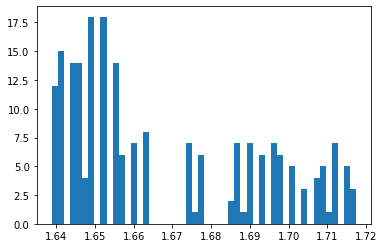

In [211]:
pts = in_dict['input'].squeeze(0).cpu().numpy()
sph_pts = cart2sph(pts)
_ = plt.hist(sph_pts[:,2], bins=50)

In [215]:
hist = np.histogram(sph_pts[:,2], bins=50)
ring_indices = np.digitize(sph_pts[:,2], hist[1][np.argwhere(hist[0] > 0).squeeze(1)])
print('num rings = ', len(np.argwhere(hist[0] > 0).squeeze(1)))
num_rings = max(ring_indices)
print('num_rings = ', num_rings)
choose_rings = np.unique(ring_indices)[np.random.randint(0,3)::np.random.randint(1,num_rings)]
mask = np.in1d(ring_indices, choose_rings)
print('num chosen rings = ', len(choose_rings))
out = sph2cart(sph_pts[mask])
print('num output points = ', out.shape)

if np.count_nonzero(mask) > 5:
    o3d.visualization.draw_geometries([convert_to_o3dpcd(out)])

num rings =  29
num_rings =  29
num chosen rings =  2
num output points =  (15, 3)


In [190]:
pts = in_dict['input'].squeeze(0).cpu().numpy()
sph_pts = cart2sph(pts)

# Doane or fd bin selection seems to do a good job at finding rings
hist = np.histogram(sph_pts[:,2], bins='doane')
print(len(hist[0]))
ringidx = np.digitize(sph_pts[:,2], hist[1])
num_rings = max(ringidx)
# # Number of rings to drop; min 1 ring remaining
# num_drop_rings = np.random.randint(0,num_rings-1,1).item()

# # Choose which rings to drop
# drop_rings = np.random.randint(0, num_rings, num_drop_rings)

choose_rings = np.unique(ringidx)[np.random.randint(0,3)::np.random.randint(1,num_rings)]
print(choose_rings)
mask = np.in1d(ringidx, choose_rings)
print(ringidx.shape)
print(mask.shape)

out = sph2cart(sph_pts[mask])
# if np.count_nonzero(mask) > min_out_pts:
#     return 

# return pts
o3d.visualization.draw_geometries([convert_to_o3dpcd(out)])

9
[1 8]
(137,)
(137,)


In [27]:
gtbox = np.random.rand(7)
partial = np.random.rand(1024,3)
complete = np.random.rand(16384,3)

partial_cn = rotate_points_along_z((partial - gtbox[:3])[np.newaxis, :, :], np.array([-gtbox[-1]]))[0]
complete_cn = rotate_points_along_z((complete - gtbox[:3])[np.newaxis, :, :], np.array([-gtbox[-1]]))[0]

noise_scale = np.random.uniform(0.7, 1, 3)    
partial_cn[:,:3] *= noise_scale
complete_cn[:,:3] *= noise_scale
gtbox[3:6] *= noise_scale

# Transform back to view-centric frame
p = rotate_points_along_z(partial_cn[np.newaxis, :, :], np.array([gtbox[-1]]))[0] + gtbox[:3]
c = rotate_points_along_z(complete_cn[np.newaxis, :, :], np.array([gtbox[-1]]))[0] + gtbox[:3]


In [31]:
def vc_to_cn(points, gt_label):
    """
    Transform the given points from view-centric to canonical frame

    For view-centric to canonical, use -angle
    For canonical to view-centric, use +angle

    Args:
        points: (B, N, 3 + C)
        gt_label: (B, 7), angle along z-axis, angle increases x ==> y
    """
    points, is_numpy = check_numpy_to_torch(points)
    gt_label, _ = check_numpy_to_torch(gt_label)

    centre = gt_label[:,:3]
    centre_points = points - centre
    points_cn = rotate_points_along_z(centre_points, -gt_label[:,-1])

    return points_cn.numpy() if is_numpy else points_cn

def vc_to_cn(points, gt_label):
    """
    Transform the given points from canonical frame to view-centric

    For view-centric to canonical, use -angle
    For canonical to view-centric, use +angle

    Args:
        points: (B, N, 3 + C)
        gt_label: (B, 7), angle along z-axis, angle increases x ==> y
    """
    points, is_numpy = check_numpy_to_torch(points)
    gt_label, _ = check_numpy_to_torch(gt_label)

    centre = gt_label[:,:3]    
    points_rot = rotate_points_along_z(points, gt_label[:,-1])
    points_vc = points + centre

    return points_vc.numpy() if is_numpy else points_vc

gt_label = np.random.rand(7)[np.newaxis, :]
partial = np.random.rand(1024,3)[np.newaxis, :]
vc_to_cn(partial, gt_label)



array([[[1.2513878 , 1.2162952 , 1.1819357 ],
        [0.6090073 , 0.9188445 , 1.0006177 ],
        [0.7022839 , 0.83695686, 0.9074545 ],
        ...,
        [0.9824947 , 1.7000049 , 1.1866556 ],
        [1.0908313 , 1.2706375 , 1.2933723 ],
        [0.55828077, 1.5947784 , 1.0871577 ]]], dtype=float32)

In [35]:
gt_label = np.random.rand(7)
assert gt_label.shape == (1,7), print('not')

not


AssertionError: None

In [12]:
_,_,data = dataset.__getitem__(6)

pts = data[0].cpu().numpy()
gpts = data[1].cpu().numpy()
gtbox = data[2]['gtbox']
boxpts = opd_to_boxpts(gtbox)
o3dgtbox = boxpts_to_o3dbox(boxpts, [1,0.9,0])

o3d.visualization.draw_geometries([convert_to_o3dpcd(pts), convert_to_o3dpcd(gpts, [0.9,0.9,0.9]), o3dgtbox])

In [44]:
norm_pts = rotate_points_along_z((pts - gtbox[:,:3]).unsqueeze(0), -gtbox[:,-1]).squeeze(0)
print(norm_pts)
norm_pts[:,:3] *= noise_scale
print(norm_pts)

tensor([[ 2.1170,  1.7164,  0.1227],
        [ 2.1340,  1.7229,  0.0981],
        [ 2.1294,  1.6747,  0.0923],
        ...,
        [ 1.1036,  3.0881, -0.1043],
        [ 1.1691,  3.0742, -0.0870],
        [ 1.1512,  3.0886, -0.1043]])
tensor([[ 1.9035,  1.5433,  0.1103],
        [ 1.9187,  1.5491,  0.0882],
        [ 1.9146,  1.5058,  0.0830],
        ...,
        [ 0.9922,  2.7766, -0.0938],
        [ 1.0511,  2.7641, -0.0782],
        [ 1.0351,  2.7771, -0.0938]])


In [18]:
_,_,data = dataset.__getitem__(37)

pts = data[1].cpu()

# gpts = data[1].cpu()
gtbox = torch.from_numpy(data[2]['gtbox']).float().unsqueeze(0)
norm_pts = rotate_points_along_z((pts - gtbox[:,:3]).unsqueeze(0), -gtbox[:,-1]).squeeze(0)

noise_scale = np.random.uniform(0.75, 1.1, 3)   
aug_pts = norm_pts.clone()
aug_pts[:,:3] *= noise_scale

origin_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0,0,0])
o3d.visualization.draw_geometries([convert_to_o3dpcd(norm_pts, [1,1,0]), convert_to_o3dpcd(aug_pts, [1,0,0]), origin_frame])

In [19]:
_,_,data = dataset.__getitem__(0)

pts = data[1].cpu()
print(pts.mean(dim=0))

# gpts = data[1].cpu()
gtbox = torch.from_numpy(data[2]['gtbox']).float().unsqueeze(0)
norm_pts = rotate_points_along_z((pts - gtbox[:,:3]).unsqueeze(0), -gtbox[:,-1]).squeeze(0)

print(norm_pts.mean(dim=0))
noise_scale = np.random.uniform(0.75, 1.1, 3)   
print(noise_scale)
norm_pts[:,:3] *= noise_scale
print(norm_pts.mean(dim=0))

vc_pts = rotate_points_along_z(norm_pts.unsqueeze(0), gtbox[:,-1]).squeeze(0) + gtbox[:,:3]
augbox = gtbox.clone()
augbox[:,3:6] *= noise_scale
print(gtbox)
print(augbox)
print(vc_pts.mean(dim=0))

# Viz
boxpts = opd_to_boxpts(gtbox.squeeze(0).cpu().numpy())
o3dgtbox = boxpts_to_o3dbox(boxpts, [1,0.9,0])

boxpts = opd_to_boxpts(augbox.squeeze(0).cpu().numpy())
o3daugbox = boxpts_to_o3dbox(boxpts, [1,0,0])
o3d.visualization.draw_geometries([o3dgtbox, o3daugbox, convert_to_o3dpcd(vc_pts, [1,0,0]), convert_to_o3dpcd(pts.numpy(), [1,0.9,0])])

tensor([-25.6106,  12.1614,  -1.6205])
tensor([ 0.1252, -0.0099,  0.0460])
[0.8973763  0.86145016 1.07060234]
tensor([ 0.1124, -0.0086,  0.0493])
tensor([[-25.7084,  12.2402,  -1.6665,   3.4060,   1.8033,   1.4007,  -0.5987]])
tensor([[-25.7084,  12.2402,  -1.6665,   3.0565,   1.5535,   1.4996,  -0.5987]])
tensor([-25.6205,  12.1698,  -1.6172])


In [13]:
# _,_,data = dataset.__getitem__(12)

# pts = data[0].cpu()
# gtbox = torch.from_numpy(data[2]['gtbox']).float().unsqueeze(0)
# gtbox_norm = gtbox.clone()
# gtbox_norm[:,:3] = 0
# gtbox_norm[:,-1] = 0
# boxpts = opd_to_boxpts(gtbox_norm.squeeze(0).cpu().numpy())
# o3dgtbox = boxpts_to_o3dbox(boxpts, [0,1,1])

# norm_pts = rotate_points_along_z((pts - gtbox[:,:3]).unsqueeze(0), -gtbox[:,-1])
# in_pcd = convert_to_o3dpcd(norm_pts.squeeze(0).cpu().numpy())
# in_pcd.paint_uniform_color([0.9,0.9,0.9])

# s = np.random.uniform(0.75,1.05, 3)
# print(s)
# augpts = norm_pts.clone().squeeze(0).cpu().numpy()
# augpts[:,0] *= s[0]
# augpts[:,1] *= s[1]
# augpts[:,2] *= s[2]
# aug_pcd = convert_to_o3dpcd(augpts)
# aug_box = boxpts.copy()
# aug_box[:,0] *= s[0]
# aug_box[:,1] *= s[1]
# aug_box[:,2] *= s[2]
# o3daug_box = boxpts_to_o3dbox(aug_box, [1,0,0])

# origin_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0,0,0])
# o3d.visualization.draw_geometries([in_pcd, aug_pcd, o3daug_box, o3dgtbox, origin_frame])

[0.98511624 0.84017119 0.81044928]


In [8]:
origin_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0,0,0])
o3d.visualization.draw_geometries([in_pcd, aug_pcd, o3dgtbox, origin_frame])

In [77]:
_,_,data = dataset.__getitem__(10)

pts = data[0].cpu().numpy()
gtbox = np.array(data[2]['gtbox'])
boxpts = opd_to_boxpts(data[2]['gtbox'])
o3dbox = boxpts_to_o3dbox(boxpts, [0,1,1])
in_pcd = convert_to_o3dpcd(pts)
in_pcd.paint_uniform_color([0.9,0.9,0.9])

augpts, augbox = GlobalScaling(pts, gtbox)

aug_pcd = convert_to_o3dpcd(augpts)
boxpts = opd_to_boxpts(augbox)
aug_o3dbox = boxpts_to_o3dbox(boxpts)

o3d.visualization.draw_geometries([in_pcd, o3dbox, aug_pcd, aug_o3dbox, origin_frame])

2.0076405819205165


In [51]:
aug_o3dbox.extent

array([4.12440401, 1.91832252, 1.18397709])

In [50]:
o3dbox.extent

array([4.40466591, 2.04867655, 1.26443081])

In [34]:
_,_,data = dataset.__getitem__(0)

in_pcd = convert_to_o3dpcd(pts)
in_pcd.paint_uniform_color([0.9,0.9,0.9])
boxpts = opd_to_boxpts(data[2]['gtbox'])
o3dbox = boxpts_to_o3dbox(boxpts)

o3d.visualization.draw_geometries([in_pcd, o3dbox])

In [123]:
gt_boxes = data[2]['gtbox']
points = data[0]
fgtbox, fpoints = RandomFlipAlongY(gt_boxes, points)

in_pcd2 = convert_to_o3dpcd(fpoints)
boxpts = opd_to_boxpts(fgtbox)
o3dbox2 = boxpts_to_o3dbox(boxpts)

o3d.visualization.draw_geometries([in_pcd, o3dbox, in_pcd2, o3dbox2])

In [23]:

loss_dict.get('he', 0.2)

0.2

In [21]:
loss_dict['dims']

tensor(1.9728, device='cuda:0', grad_fn=<MeanBackward0>)

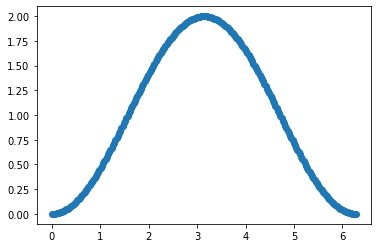

In [30]:
pred1 = np.array([0.0 for i in range(250)])
pred2 = np.linspace(0,2*np.pi, 250)
cos1 = np.cos(pred1)
cos2 = np.cos(pred2)
plt.scatter(pred2, abs(cos1-cos2))

In [317]:
heading_err = -1.7499 - 1.5708
cos_sim = (1.0 + np.cos(heading_err))/2.0
cos_sim

0.007998443909987829

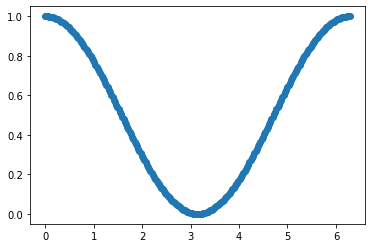

In [315]:
heading_err = pred1 - pred2
cos_sim = (1.0 + np.cos(heading_err))/2.0
plt.scatter(pred2, cos_sim)

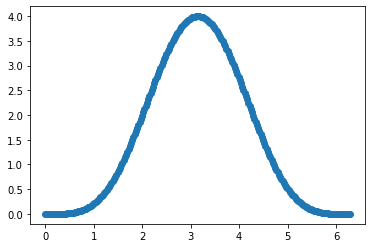

In [313]:
torchloss = nn.MSELoss(reduction='none')
l1loss = torchloss(torch.from_numpy(cos1), torch.from_numpy(cos2))
plt.scatter(pred2, l1loss)

# PCNSSC

In [4]:
import torch
import torch.nn as nn
import numpy as np
from extensions.chamfer_dist import ChamferDistanceL2
    
def mlp_conv(in_channels, layer_dims, bn=None, bn_params=None):
    layers = []
    for i, out_channel in enumerate(layer_dims[:-1]):
        layers += [nn.Conv1d(in_channels, out_channel, kernel_size=1)]
        in_channels = out_channel

    layers += [nn.Conv1d(in_channels, layer_dims[-1], kernel_size=1)]
    mlp_block = nn.Sequential(*layers)
    
    return nn.Sequential(*layers)

class PCNencoder(nn.Module):
    def __init__(self):
        super(PCNencoder, self).__init__()
        self.mlp_conv1 = nn.Sequential(
            nn.Conv1d(3,128,1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128,256,1)
        )
        self.mlp_conv2 = nn.Sequential(
            nn.Conv1d(512,512,1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512,1024,1)
        )
        
    def point_maxpool(self, inputs, npts, keepdims):
        # Max pool to get a 256 feature vec for the whole object 
        # [(1,256,1),(1,256,1),...] of len=batchsize
        outputs = [torch.max(f, dim=2, keepdim=keepdims)[0] for f in torch.split(inputs, npts, dim=2)]
        return torch.cat(outputs, dim=0)
    
    def point_unpool(self, inputs, npts):
        # Assign same 256 features to all points in the original object pcd
        # [(1,256,N1),(1,256,N2),...] of len=batchsize
        outputs = [torch.tile(f, [1, 1, npts[i]]) for i,f in enumerate(inputs)]

        return torch.cat(outputs, dim=2)

    def forward(self, x, npts_per_id):
        # Pytorch is (B,C,N) format
        # input is (1,3,sum(Ni->b)), Ni refers to the specific num pts in an object
        print(x.shape)
        mlp_feat = self.mlp_conv1(x) # 1 256 N
        print(mlp_feat.shape)
        symmetric_feat = self.point_maxpool(mlp_feat, npts_per_id, keepdims=True)  # [(1,256,1),(1,256,1),...] of len=B
        symmetric_feat = self.point_unpool(symmetric_feat, npts_per_id)  # (1,256,sum(Ni->b)) 
        
        # Concatenate global (symmetric) and point (mlp) features
        features = torch.cat([mlp_feat, symmetric_feat], dim=1)

        # Process the combined features
        combined_feat = self.mlp_conv2(features)  # (1,1024,sum(Ni->b))
        combined_feat = self.point_maxpool(combined_feat, npts_per_id, keepdims=False)  # (B,1024,1)
        # 1 global 1024-feature vector per object (i.e. 1024 channels)
        return combined_feat

class PCNdecoder(nn.Module):
    def __init__(self):
        super(PCNdecoder, self).__init__()
        self.grid_scale = 0.05
        self.grid_size = 4
        self.num_coarse = 1024
        self.num_fine = self.grid_size ** 2 * self.num_coarse
        self.mlp = nn.Sequential(
            nn.Linear(self.num_coarse,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,3*self.num_coarse)
        )
        self.final_conv = nn.Sequential(
            nn.Conv1d(1024+3+2,512,1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512,512,1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512,3,1)
        )
    def forward(self, x):

        # Coarse completion
        coarse = self.mlp(x) # (B,num_coarse*3)
        coarse = coarse.reshape([-1, 3, self.num_coarse]) # We set num_coarse*3 above so that we can bring it back to 3 channels
        
        # --- Fine completion ---
        # 2D grid u x u for each coarse point
        u = torch.linspace(start=-self.grid_scale, end=self.grid_scale, steps=self.grid_size).cuda() # create 4x4 grid
        grid = torch.meshgrid(u,u) # (4,4) and (4,4)
        grid = torch.unsqueeze(torch.reshape(torch.stack(grid, dim=2), (2,-1)),0) # (1,16,2)
        folding_seed = torch.tile(grid, [x.shape[0], 1, self.num_coarse]) # grid*num_coarse
        
        point_feat = torch.tile(torch.unsqueeze(coarse, 2), [1, 1, self.grid_size **2, 1])
        point_feat = point_feat.reshape([-1, 3, self.num_fine])
        
        global_feat = torch.tile(x.unsqueeze(2), [1, 1, self.num_fine])
        feat = torch.cat([folding_seed, point_feat, global_feat], dim=1)
        center = torch.tile(torch.unsqueeze(coarse, 2), [1, 1, self.grid_size ** 2, 1])
        center = center.reshape([-1, 3, self.num_fine])
        
        fine = self.final_conv(feat) + center

        return coarse, fine

class PCNSSC(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = PCNencoder()
        self.decoder = PCNdecoder()
        self.build_loss_func()

    def build_loss_func(self):
        self.loss_func = ChamferDistanceL2()

    def get_loss(self, ret, gt):
        gt_ds = gt[:, :ret[0].shape[1], :] # random downsample
        loss_coarse = self.loss_func(ret[0], gt_ds)
        loss_fine = self.loss_func(ret[1], gt)
        return loss_coarse, loss_fine
            
    def forward(self, x, npts):
        x = x.permute(0,2,1)
        encoded_feats = self.encoder(x, npts)
        coarse, fine = self.decoder(encoded_feats)
        return (coarse.transpose(1,2).contiguous(), fine.transpose(1,2).contiguous())

In [5]:
import torch
from utils.misc import *
dataset = build_dataset_from_cfg(config.dataset.train._base_, config.dataset.train.others)
shuffle = config.dataset.train.others.subset == 'train'
sampler = None
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2,
                                        shuffle = shuffle, 
                                        drop_last = config.dataset.train.others.subset == 'train',
                                        num_workers = 4,
                                        worker_init_fn=worker_init_fn,
                                        collate_fn=collate_variable_input)

model = PCNSSC()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device, dtype=torch.float)

_, model_ids, data = next(iter(dataloader))
partial = data[0].to(device, dtype=torch.float)
complete = data[1].to(device, dtype=torch.float)
out = model(partial, data[2]['num_pts'])

2022-03-31 04:26:12,473 - VC_DATASET - INFO - Complete collecting files for train. Total views: 3200


torch.Size([1, 3, 4096])
torch.Size([1, 256, 4096])
